In [33]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def DarkChannel(im, sz):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    dark = cv2.erode(dc, kernel)
    return dark

In [35]:
def AtmLight(im, dark):
    [h, w] = im.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 1000), 1))
    darkvec = dark.reshape(imsz, 1)
    imvec = im.reshape(imsz, 3)

    indices = darkvec.argsort()
    indices = indices[imsz - numpx::]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A

In [36]:
def TransmissionEstimate(im, A, sz):
    omega = 0.95
    im3 = np.empty(im.shape, im.dtype)

    for ind in range(0, 3):
        im3[:, :, ind] = im[:, :, ind] / A[0, ind]

    transmission = 1 - omega * DarkChannel(im3, sz)
    return transmission

In [37]:
def Guidedfilter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * im + mean_b
    return q

In [38]:
def TransmissionRefine(im, et):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 60
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)

    return t

In [39]:
def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype)
    t = cv2.max(t, tx)

    for ind in range(0, 3):
        res[:, :, ind] = (im[:, :, ind] - A[0, ind]) / t + A[0, ind]

    return res

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


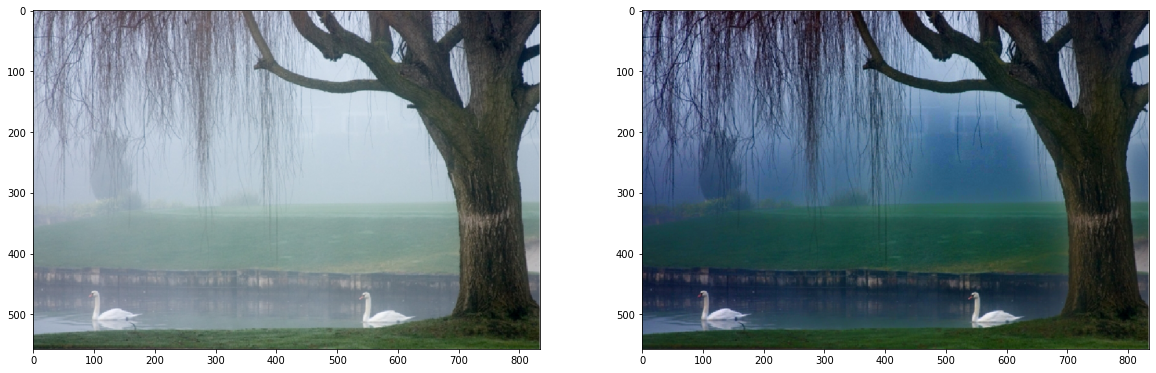

In [42]:
imgOriginal = cv2.imread("dataset/swan.jpg")
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2RGB)
img = img.astype('float64') / 255

dark = DarkChannel(img, 15)
A = AtmLight(img, dark)
te = TransmissionEstimate(img, A, 15)
t_refined = TransmissionRefine(imgOriginal, te)
J = Recover(img, t_refined, A, 0.1)

plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(J,cmap="gray")
plt.show()